In [1]:
import pydicom
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the file paths
input_file_path = 'node-coordinate.rpt'
# output_file_path = 'extracted_table.csv'

# extracting node-coordinates:

In [2]:
# Read the .rpt file
with open(input_file_path, 'r') as file:
    lines = file.readlines()

# Identify the start of the table
start_line = 13

# Extract the data from the table
table_data = []
for line in lines[start_line + 1:]:
    if line.strip() == "" or line.startswith("----") or "X" in line or "Orig. Coords" in line:
        continue
    parts = line.split()
    part_instance = parts[0]
    node_id = int(parts[1])
    orig_coords = list(map(float, parts[2:5]))
    def_coords = list(map(float, parts[5:]))
    table_data.append([part_instance, node_id] + orig_coords + def_coords)

# Create a DataFrame
columns = ['Part Instance', 'Node ID', 'Orig X', 'Orig Y', 'Orig Z', 'Def X', 'Def Y', 'Def Z']
df_node_coords = pd.DataFrame(table_data, columns=columns)

In [3]:
df_node_coords["Orig Y"].max()

np.float64(244.44)

In [4]:
nodes_coordinates = df_node_coords[["Node ID", "Orig X", "Orig Y", "Orig Z"]]
nodes_coordinates.reset_index(inplace=True, drop=True)
nodes_coordinates.head()

,Node ID,Orig X,Orig Y,Orig Z
0,1,89.7910,232.513,28.85
1,2,113.9430,213.146,28.85
2,3,133.2090,236.151,28.85
3,4,80.7107,213.150,28.85
4,5,103.8230,202.393,28.85


In [5]:
nodes_coordinates.loc[:, ["Orig X", "Orig Y", "Orig Z"]] = nodes_coordinates[["Orig X", "Orig Y", "Orig Z"]]/0.148
nodes_coordinates.head()

,Node ID,Orig X,Orig Y,Orig Z
0,1,606.695946,1571.033784,194.932432
1,2,769.885135,1440.175676,194.932432
2,3,900.060811,1595.614865,194.932432
3,4,545.342568,1440.202703,194.932432
4,5,701.506757,1367.520270,194.932432


In [6]:
node_ids = nodes_coordinates["Node ID"].tolist()
# nodes_in_first_layer_id

In [7]:
nodes_coordinates.loc[nodes_coordinates["Node ID"].isin([572, 584, 53, 52]), "Orig Z"]

51     194.932432
52     194.932432
571    194.932432
583    194.932432
Name: Orig Z, dtype: float64

# extracting node-elements (each element is cnosisting of what nodes?):

In [8]:
import pandas as pd

# Define the file paths
input_file_path_element = 'element-node.rpt'
# output_file_path = 'extracted_table.csv'

In [9]:
# Read the .rpt file
with open(input_file_path_element, 'r') as file:
    lines = file.readlines()

node_ids_set = set(node_ids)  # Convert to set if not already a set
# Identify the start of the table
start_line = 15

# Extract the data from the table
table_data = []
not_table_data = []

for line in lines[start_line + 1:]:
    if line.strip() == "" or line.startswith("----") or "Part" in line or "X" in line or "Orig. Coords" in line:
        continue
    parts = line.split()
    part_instance = parts[0]
    element_id = int(parts[1])
    Type = str(parts[2])
    attached_nodes = list(map(int, parts[3:]))
    first_attached_node = attached_nodes[0]

    # Use list comprehension to filter nodes that have same Orig Z
    attached_nodes = [
    node for node in attached_nodes 
    if nodes_coordinates.loc[nodes_coordinates["Node ID"] == node, "Orig Z"].values[0] 
    == nodes_coordinates.loc[nodes_coordinates["Node ID"] == first_attached_node, "Orig Z"].values[0]
    ]

    element_to_be_append = [part_instance,  element_id, Type] + attached_nodes

    if len(element_to_be_append) == 7:
        table_data.append(element_to_be_append)



In [10]:
len(table_data)

40768

In [11]:
# Create a DataFrame
columns = ['Part Instance', 'Element ID', 'Type', "Attached nodes 1", "Attached nodes 2", "Attached nodes 3", "Attached nodes 4"]
zone_nodes = pd.DataFrame(table_data, columns=columns)
zone_nodes.head()

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4
0,FEM-1,1,C3D8R,572,584,53,52
1,FEM-1,2,C3D8R,584,585,54,53
2,FEM-1,3,C3D8R,585,586,55,54
3,FEM-1,4,C3D8R,586,587,56,55
4,FEM-1,5,C3D8R,587,588,57,56


In [12]:
zone_nodes.dtypes

Part Instance       object
Element ID           int64
Type                object
Attached nodes 1     int64
Attached nodes 2     int64
Attached nodes 3     int64
Attached nodes 4     int64
dtype: object

In [13]:
zone_nodes

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4
0,FEM-1,1,C3D8R,572,584,53,52
1,FEM-1,2,C3D8R,584,585,54,53
2,FEM-1,3,C3D8R,585,586,55,54
3,FEM-1,4,C3D8R,586,587,56,55
4,FEM-1,5,C3D8R,587,588,57,56
...,...,...,...,...,...,...,...
40763,FEM-1,40764,C3D8R,42924,42923,40281,40282
40764,FEM-1,40765,C3D8R,42923,40277,39894,40281
40765,FEM-1,40766,C3D8R,42923,40414,39895,40277
40766,FEM-1,40767,C3D8R,42924,40415,40414,42923


# The process to be done, using provided dataframes:

In [14]:
def draw_zone_boundaries(image, nodes_coordinates, zone_nodes):
    for zone in zone_nodes:
        # Getting coordinates of the nodes for each zone
        pts = np.array([nodes_coordinates[node_id] for node_id in zone], np.int32)
        pts = pts.reshape((-1, 1, 2))
        # Drawing zone boundaries
        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=1)
    return image

In [15]:
def calculate_zone_hounsfield(image, nodes_coordinates, zone_nodes):
    zone_hounsfield = []
    for zone in zone_nodes:
        # Getting coordinates of the nodes for each zone
        pts = np.array([nodes_coordinates[node_id] for node_id in zone], np.int32)
        # Creating a mask for the zone
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.fillPoly(mask, [pts], 255)
        # Calculating the mean Hounsfield value in the zone using the mask
        mean_hounsfield = cv2.mean(image, mask=mask)[0]
        zone_hounsfield.append(mean_hounsfield)
    
    return zone_hounsfield

In [16]:
# Main function to process the DICOM image and calculate mean Hounsfield values for each zone
def process_dicom_image(dicom_path, nodes_df, elements_df):
    # Load the DICOM file using pydicom
    dicom_file = pydicom.dcmread(dicom_path)
    image = dicom_file.pixel_array
    
    # Convert to Hounsfield Units (if necessary)
    intercept = dicom_file.RescaleIntercept if 'RescaleIntercept' in dicom_file else 0
    slope = dicom_file.RescaleSlope if 'RescaleSlope' in dicom_file else 1
    hounsfield_image = image * slope + intercept
    
    # Extract node coordinates
    nodes_coordinates = {row['Node ID']: (row['Orig X'], row['Orig Y']) for _, row in nodes_df.iterrows()}
    
    # Extract nodes for each zone
    zone_nodes = elements_df[['Attached nodes 1', 'Attached nodes 2', 'Attached nodes 3', 'Attached nodes 4']].values.tolist()
    
    # Draw boundaries around zones on the original DICOM image
    image_with_zones = draw_zone_boundaries(hounsfield_image.copy(), nodes_coordinates, zone_nodes)
    
    # Calculate the mean Hounsfield value for each zone
    zone_hounsfield = calculate_zone_hounsfield(hounsfield_image, nodes_coordinates, zone_nodes)
    
    # Add the mean Hounsfield values to the elements dataframe
    elements_df['Mean Hounsfield'] = zone_hounsfield
    
    # Display the image with zone boundaries
    plt.imshow(image_with_zones, cmap='gray')
    plt.title('DICOM Image with Zone Boundaries')
    plt.show()

    return elements_df

In [17]:
import os

dicom_path = r"D:\Mammad's Project\development_environment\00000005.dcm"  # Path to the DICOM file
print(os.path.exists(dicom_path))  # Should return True if the DICOM file exists

dicom_file = pydicom.dcmread(dicom_path)
image = dicom_file.pixel_array
image    

True


array([[    0,     0,     0, ..., 65535, 65535, 61387],
       [    0,     0,     0, ..., 65535, 65535, 60107],
       [    0,     0,     0, ..., 65535, 65535, 59467],
       ...,
       [    0,     0,     0, ..., 65535, 65535, 61849],
       [ 9082,  9720, 10423, ..., 65535, 65535, 63499],
       [20293, 20641, 21427, ..., 65535, 65535, 64320]], dtype=uint16)

In [18]:
# image = cv2.imread(image_path)
# # cv2.imshow("image", image)
# plt.imshow(image)

In [19]:
nodes_coordinates["Orig Y"] = -nodes_coordinates["Orig Y"] + image.shape[0]

C:\Users\asus\AppData\Local\Temp\ipykernel_19080\773424873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_coordinates["Orig Y"] = -nodes_coordinates["Orig Y"] + image.shape[0]


In [20]:
print(image.shape)

(2879, 2854)


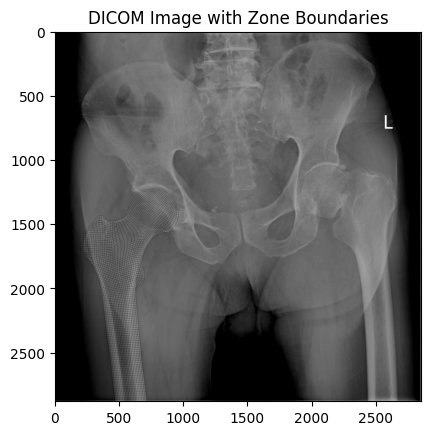

      Part Instance  Element ID   Type  Attached nodes 1  Attached nodes 2  \
0             FEM-1           1  C3D8R               572               584   
1             FEM-1           2  C3D8R               584               585   
2             FEM-1           3  C3D8R               585               586   
3             FEM-1           4  C3D8R               586               587   
4             FEM-1           5  C3D8R               587               588   
...             ...         ...    ...               ...               ...   
40763         FEM-1       40764  C3D8R             42924             42923   
40764         FEM-1       40765  C3D8R             42923             40277   
40765         FEM-1       40766  C3D8R             42923             40414   
40766         FEM-1       40767  C3D8R             42924             40415   
40767         FEM-1       40768  C3D8R             42922             40416   

       Attached nodes 3  Attached nodes 4  Mean Hounsfield  
0 

In [21]:
# اجرای تابع اصلی
processed_elements_df = process_dicom_image(dicom_path, nodes_coordinates, zone_nodes)
# نمایش دیتافریم نهایی با میانگین روشنایی هر المان
print(processed_elements_df)

In [22]:
processed_elements_df

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4,Mean Hounsfield
0,FEM-1,1,C3D8R,572,584,53,52,33139.053571
1,FEM-1,2,C3D8R,584,585,54,53,32943.475410
2,FEM-1,3,C3D8R,585,586,55,54,32880.816901
3,FEM-1,4,C3D8R,586,587,56,55,31959.703030
4,FEM-1,5,C3D8R,587,588,57,56,32070.876404
...,...,...,...,...,...,...,...,...
40763,FEM-1,40764,C3D8R,42924,42923,40281,40282,17681.566138
40764,FEM-1,40765,C3D8R,42923,40277,39894,40281,19872.580645
40765,FEM-1,40766,C3D8R,42923,40414,39895,40277,16305.458128
40766,FEM-1,40767,C3D8R,42924,40415,40414,42923,15007.147783


In [23]:
processed_elements_df["Mean Hounsfield - Converted"] = (processed_elements_df["Mean Hounsfield"] + 1024)/16 - 1024

In [33]:
processed_elements_df

,Part Instance,Element ID,Type,Attached nodes 1,Attached nodes 2,Attached nodes 3,Attached nodes 4,Mean Hounsfield,Mean Hounsfield - Converted
0,FEM-1,1,C3D8R,572,584,53,52,33139.053571,1111.190848
1,FEM-1,2,C3D8R,584,585,54,53,32943.475410,1098.967213
2,FEM-1,3,C3D8R,585,586,55,54,32880.816901,1095.051056
3,FEM-1,4,C3D8R,586,587,56,55,31959.703030,1037.481439
4,FEM-1,5,C3D8R,587,588,57,56,32070.876404,1044.429775
...,...,...,...,...,...,...,...,...,...
40763,FEM-1,40764,C3D8R,42924,42923,40281,40282,17681.566138,145.097884
40764,FEM-1,40765,C3D8R,42923,40277,39894,40281,19872.580645,282.036290
40765,FEM-1,40766,C3D8R,42923,40414,39895,40277,16305.458128,59.091133
40766,FEM-1,40767,C3D8R,42924,40415,40414,42923,15007.147783,-22.053264


In [44]:
sorted(processed_elements_df["Mean Hounsfield - Converted"].unique().tolist())

[-97.25253807106606,
 -56.270615183246036,
 -32.654411764705856,
 -22.053263546798007,
 -13.642131979695478,
 -13.085025380710704,
 -11.626785714285575,
 -11.01300761421328,
 -8.588541666666629,
 -7.944479695431596,
 3.7334104938272503,
 19.220192307692287,
 33.14793165467631,
 34.42391304347825,
 52.14356435643549,
 59.09113300492618,
 62.87308673469374,
 63.30742385786789,
 67.27411167512673,
 68.49632352941171,
 69.25972877358481,
 70.67798223350246,
 74.38043478260875,
 77.9140228426395,
 79.9980964467004,
 80.73469387755085,
 81.58724619289342,
 85.8498086734694,
 87.84191176470586,
 88.0845588235295,
 94.49715909090901,
 94.94447969543148,
 98.56027918781729,
 99.07931472081214,
 99.43382352941171,
 99.66021573604053,
 102.34263959390864,
 104.45361842105262,
 107.54367897727275,
 112.62848984771563,
 114.14809113300498,
 122.65068069306926,
 123.85140931372553,
 129.0878205128206,
 129.25285532994917,
 131.36314102564097,
 132.6157994923858,
 138.44194162436543,
 140.61666666666

In [29]:
# Grouping by "Mean Hounsfield - Converted" and aggregating the corresponding Element IDs
unique_meanHansfield_values = processed_elements_df.groupby('Mean Hounsfield - Converted')['Element ID'].apply(list).reset_index()

# Renaming columns for clarity
unique_meanHansfield_values.columns = ['Mean Hounsfield - Converted', 'Element IDs']

unique_meanHansfield_values.head()


,Mean Hounsfield - Converted,Element IDs
0,-97.252538,"[2885, 5797, 8709, 11621, 14533, 17445, 20357,..."
1,-56.270615,"[2865, 5777, 8689, 11601, 14513, 17425, 20337,..."
2,-32.654412,"[2845, 5757, 8669, 11581, 14493, 17405, 20317,..."
3,-22.053264,"[2911, 5823, 8735, 11647, 14559, 17471, 20383,..."
4,-13.642132,"[2765, 5677, 8589, 11501, 14413, 17325, 20237,..."


In [46]:
unique_meanHansfield_values.shape

(2912, 2)

In [29]:
# Save the DataFrame to an Excel file
value_counts = processed_elements_df["Mean Hounsfield"].value_counts()
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Mean Hounsfield', 'Count']

value_counts_converted = processed_elements_df["Mean Hounsfield - Converted"].value_counts()
value_counts_df_converted = value_counts_converted.reset_index()
value_counts_df_converted.columns = ['Mean Hounsfield - Converted', 'Count']


# Save the DataFrame to an Excel file
value_counts_df.to_excel("mean_hounsfield_value_counts.xlsx", index=False)
value_counts_df_converted.to_excel("mean_hounsfield_value_counts_converted.xlsx", index=False)

In [28]:
# Save the DataFrame to a CSV file
output_file_path = "zones_mean_hounsfield.csv"
processed_elements_df.to_csv(output_file_path, index=False)

output_file_path = "zones_mean_hounsfield.xlsx"
processed_elements_df.to_excel(output_file_path, index=False)

print(f"Table extracted and saved to {output_file_path} as CSV and Excel.")

Table extracted and saved to zones_mean_hounsfield.xlsx as CSV and Excel.
